In [1]:
from mltoolbox.basic import *

In [2]:
plt.rcParams['figure.figsize'] = [15.0, 6.0]

In [3]:
%matplotlib inline

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms

from pathlib import Path

In [5]:
import math, os

In [6]:
PATH = Path("data/train_spectograms/")
len(list(PATH.iterdir()))

8712

In [7]:
im = Image.open(PATH/'1.jpg')

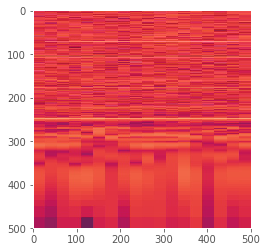

In [8]:
plt.imshow(np.asarray(im))
plt.grid(False)

In [9]:
sz=500

In [10]:
from mltoolbox.image import stats_dict

In [11]:
df = folder2df(fpath=PATH)

In [12]:
df['signal_id'] = df.fname.apply(lambda x: int(str(x).split('/')[-1].split('.')[0]))

In [13]:
df.head()

,fname,label,signal_id
0,data/train_spectograms/0.jpg,train_spectograms,0
1,data/train_spectograms/1.jpg,train_spectograms,1
2,data/train_spectograms/10.jpg,train_spectograms,10
3,data/train_spectograms/100.jpg,train_spectograms,100
4,data/train_spectograms/1000.jpg,train_spectograms,1000


In [14]:
train_meta = pd.read_csv('data/metadata_train.csv')

In [15]:
train_meta.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [16]:
df = df.join(train_meta, on=['signal_id'], how='left', lsuffix='_l'
             )[['fname', 'signal_id', 'id_measurement', 'phase', 'target']]

In [17]:
df.head()

,fname,signal_id,id_measurement,phase,target
0,data/train_spectograms/0.jpg,0,0,0,0
1,data/train_spectograms/1.jpg,1,0,1,0
2,data/train_spectograms/10.jpg,10,3,1,0
3,data/train_spectograms/100.jpg,100,33,1,0
4,data/train_spectograms/1000.jpg,1000,333,1,0


In [18]:
from mltoolbox.plotting import *

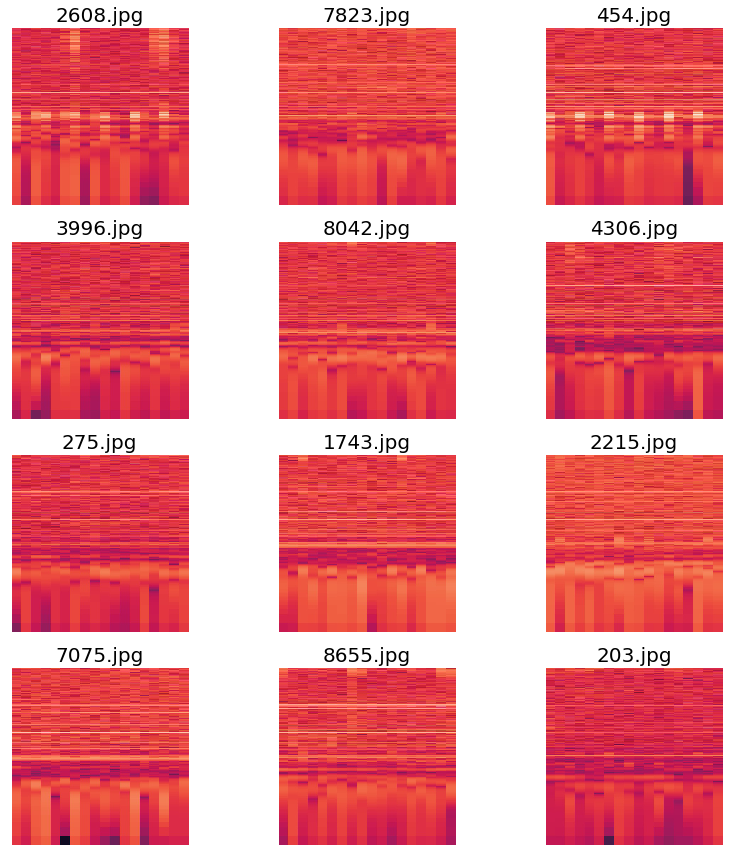

In [19]:
multi_plot(df.fname.apply(lambda x: str(x)).sample(n=12).values)

In [20]:
train, valid = split_df(df)

In [21]:
train.target.value_counts()

0    6590
1     400
Name: target, dtype: int64

In [22]:
valid.target.value_counts()

0    1597
1     125
Name: target, dtype: int64

In [23]:
from mltoolbox.image import *

In [24]:
class SpectrogramDataset(Dataset):
    def __init__(self, df):
        self.num_files = df.shape[0]
        self.file_path = df.fname.values
        self.labels = df.target.values

    def __len__(self):
        return self.num_files

    def __getitem__(self, idx):
        y = self.labels[idx]
        fpath = str(self.file_path[idx])
        x = imread_fast(fpath)
        x = hcyclic_shift(x, alpha=0.5)
        x = im_int2float(x)
        x = normalize_image(x)
        x =  np.rollaxis(x, 2)
        return x, y

In [25]:
train_ds = SpectrogramDataset(train)
valid_ds = SpectrogramDataset(valid)

In [26]:
len(train_ds)

6990

In [27]:
len(valid_ds)

1722

In [28]:
x, y = train_ds[900]
x.shape, y

((3, 500, 500), 0)

# Note
While next-iter num_workers low is good, but while actual training num_workers high is good.

In [53]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

In [31]:
len(train_dl)

110

In [87]:
resnet = models.resnet34(pretrained=True)

In [88]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        # x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        # x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [89]:
model = Net().cuda()

In [37]:
x, y = next(iter(valid_dl))

In [38]:
x = x.cuda().float()
y = y.cuda().float()
x.shape

torch.Size([64, 3, 500, 500])

In [39]:
y.shape

torch.Size([64])

In [40]:
x_features = model.top_model(x)
x_features.shape

torch.Size([64, 512, 16, 16])

In [41]:
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)
x_features_ave.shape

torch.Size([64, 512, 1, 1])

In [42]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([64, 512])

In [43]:
y_hat = model(x)
y_hat.shape

torch.Size([64, 1])

In [44]:
y

tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [45]:
y_hat.squeeze().detach().cpu() > 0

tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0], dtype=torch.uint8)

In [47]:
from mltoolbox.dl import get_optimizer, save_model, load_model, lr_range_finder

In [48]:
from mltoolbox.dl import plot_lr

In [49]:
loss_criteria = F.binary_cross_entropy_with_logits

In [50]:
plt.rcParams['figure.figsize'] = [15.0, 6.0]

In [57]:
log_lrs, losses, smooth_losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                                                 lr_high=0.1, loss_criteria=loss_criteria,
                                                 epochs=1)

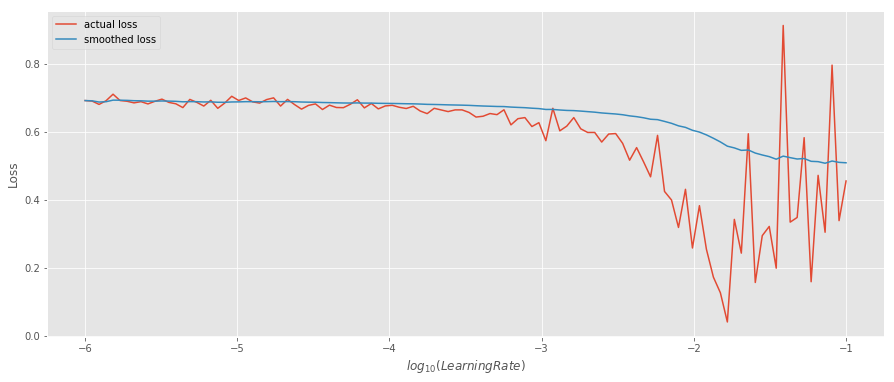

In [58]:
plot_lr(log_lrs, losses, smooth_losses)

In [59]:
best_lr = 10**(-1.75)
best_lr

0.01778279410038923

In [63]:
from mltoolbox.dl import get_triangular_lr, val_metrics, train_triangular_policy,\
    training_loop

In [60]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=8, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

model = Net().cuda()

In [61]:
from sklearn.metrics import matthews_corrcoef, accuracy_score

In [64]:
val_metrics(model=model, valid_dl=valid_dl,
            metrics=[accuracy_score, matthews_corrcoef], loss_criteria=loss_criteria)

{'val_loss': 0.6984992174044442,
 'accuracy_score': 0.21777003484320556,
 'matthews_corrcoef': 0.08112642282722642}

In [69]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=0.0177, epochs=3)

Epoch No.:1, Train loss: 0.3213, val_loss: 0.3801, accuracy_score: 0.9280, matthews_corrcoef: 0.0862, 
Epoch No.:2, Train loss: 0.1968, val_loss: 0.2332, accuracy_score: 0.9350, matthews_corrcoef: 0.3116, 
Epoch No.:3, Train loss: 0.1460, val_loss: 0.1711, accuracy_score: 0.9413, matthews_corrcoef: 0.4564, 
train_triangular_policy 596.20 s


In [70]:
save_model(model, 'models/frozen.mdl')

In [83]:
load_model(model, 'models/frozen.mdl')

In [72]:
from mltoolbox.dl import set_trainable_attr, unfreeze

In [73]:
for i in range(3, 8):
    unfreeze(model, i)

Since more parameters are trained now need to reduce batch size to make space in GPU memory

In [90]:
model = model.cuda()

In [85]:
batch_size = 24

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

In [76]:
log_lrs, losses, smooth_losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                                                 lr_high=0.1, loss_criteria=loss_criteria,
                                                 epochs=1)

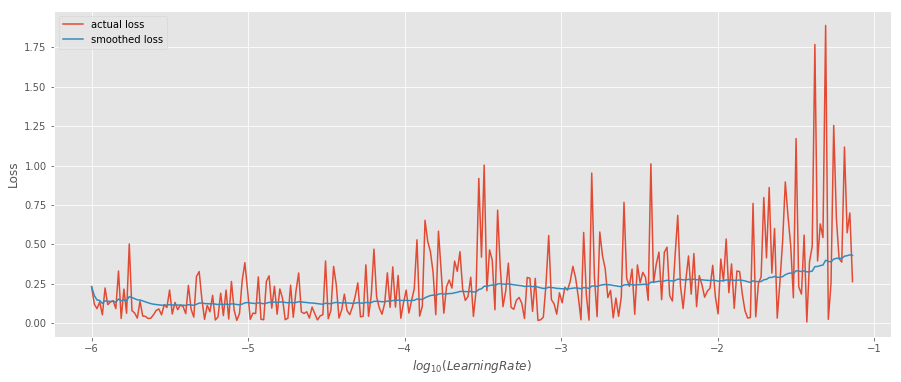

In [78]:
plot_lr(log_lrs, losses, smooth_losses)

In [96]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-4), epochs=1)

Epoch No.:1, Train loss: 0.3519, val_loss: 0.3241, accuracy_score: 0.9350, matthews_corrcoef: 0.3325, 
train_triangular_policy 127.33 s


In [97]:
save_model(model, 'models/unfreeze1.mdl')
load_model(model, 'models/unfreeze1.mdl')

In [102]:
y_pred, y_true = predict(model, valid_dl, is_valid=True)

In [103]:
from sklearn.metrics import confusion_matrix

In [106]:
confusion_matrix(y_true=y_true, y_pred=y_pred)

array([[1588,    9],
       [ 103,   22]])

In [107]:
from mltoolbox.plotting import plot_confusion_matrix

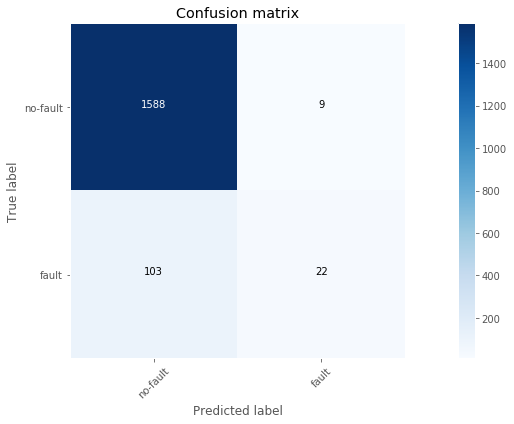

In [110]:
plot_confusion_matrix(confusion_matrix(y_true=y_true, y_pred=y_pred),
                      classes=['no-fault', 'fault'])
plt.grid()

In [111]:
matthews_corrcoef(y_pred=y_pred, y_true=y_true)

0.33245567202284376